
# Black-Litterman
Tomaremos como base dos notebooks sobre el _BL Model_:
* https://github.com/omartinsky/BlackLitterman/blob/master/black_litterman.ipynb
* https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb

#### Mathematical symbols used in this notebook

| Python var | Math Symbol | Comentario
| -- | -- | --
| rf | $r$ | risk free rate
| lmb | $\lambda$ | factor de risk-aversion
| C | $C$ | Matriz de covarianzas muestral
| V | $V$ | Diagonal en la matriz de covarianzas
| W | $W$ | Ponderaciones de los activos
| R | $R$ | Retornos de los activos
| mean | $\mu$ | Retorno muestral
| var | $\sigma$ | Varianza muestral
| Pi | $\Pi$ | Excesos de retornos de equilibrio del portafolio
| tau | $\tau$ | Escalar de BL

In [1]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 6)
import scipy.optimize
from pandas import *

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Algunas funciones

In [2]:
## Nota: con doble # son mis comentarios (mauro)

In [3]:
## define 3 funciones: una que calcula la media de retornos del portfolio, una que calcula la varianza
## y una que llama a las dos funciones anteriores y las devuelve

# Media del portafolio
def port_mean(W, R):
    return sum(R * W)

# Varianza del portafolio
def port_var(W, C):
    return dot(dot(W, C), W)

def port_mean_var(W, R, C):
    return port_mean(W, R), port_var(W, C)

In [4]:
# Dado inputs (retornos, covarianzas y la rf) resuelve al frontera eficiente y devuelve un array de coordenadas (en el plano)
# riesgo-retorno
def solve_frontier(R, C, rf):
    
    ## va a definir una funcion de fitness adentro de la función.
    ## esto es lo que va a usar en el optimizador despues para minimizar
    ## se suele llamar función de costo. Por ahí los ingenieros lo vieron como "el funcional"
    ## del proceso de optimización. 
        
    
    def fitness(W, R, C, r):  
        
        # Para un nivel determinado de retorno encuentra el portafolio que minimiza el riesgo..
        
        ## acá solo calcula la función que va a optimizar. Todavía no optimiza nada. 
        ## Lo que vamos a ver es un poco diferente a lo que ya vimos para minima varianza:
        ## acá toma un vector de pesos W, un vector de retornos R, una matriz de
        ## varianzas y covarianzas C y un retorno objetivo r (¿cuánto quiero de retorno?)
        ## para ese retorno objetivo r encuentra el portfolio de minima varianza 
        ## (es un poco distinto a lo que vimos la otra vez para encontrarlo)
    
        
        ## toma R (vector de retornos), C (matriz de varianza y covarianza) y W (los pesos)
        ## y calcula media y varianza de un portfolio con esos pesos
        mean, var = port_mean_var(W, R, C)
        
        ## calcula una función de costo para el optimizador: 
        ## el valor absoluto de la diferencia entre la media del portfolio y el retorno objetivo
        ## eso multiplicado por 100
        ## a eso le suma la varianza del portfolio. 
        
        ## Entonces esto te devuelve la varianza del portfolio + la diferencia entre 
        ## el target y el retorno objetivo.
        ## O sea, cuando lo optimicemos, vamos a encontrar los pesos
        ## que minimizan la varianza pero penalizando por distancia al retorno target 
        
        
        penalty = 100* abs(
            mean - r)
        
        return var + penalty

    ## acá es donde hacemos la optimización: 
    
    ## definimos unas listas vacías para guardar los resultados
    frontier_mean, frontier_var, frontier_weights = [], [], []
    
    ## definimos n como el numero de activos en el portfolio
    n = len(R)  # n_assets del portafolio
    
    ## lo que vamos a hacer es iterar por 20 retornos target y buscar los pesos que minimizan la varianza
    ## para cada uno de esos 20 retornos.
    ## ¿entre que valores buscamos? Entre el portfolio con 1 solo activo que tiene el mejor retorno
    ## y el portfolio con 1 solo activo que tiene el mejor retorno
    
    for r in linspace(min(R), max(R), num=20):  # Planteamos 20 portafolios para la grilla de valores. 
        
        ## como scipy pide un lugar para empezar a buscar, le damos pesos distribuidos de manera uniforme
        ## acá hacemos un vector con un 1 para cada acrivo y los dividimos por la cantidad de activos
        W = ones([n]) / n  # empezamos con ponderaciones 1/n_assets
        
        ## definimos el bound de que los pesos para que estén entre 0 y 1
        ## esto limita la busqueda del optimizador:
        ## es una lista de tuplas (0,1), una para cada activo
        ## esto le dice a scipy, para cada activo, que el peso minimo es el de la izquierda (0)
        ## y el maaximo el de la derecha (1)
        b_ = [(0, 1) for i in range(n)] # long only
        
        ## definimos una restricción de que la suma de los pesos sea 1
        ## para los constrains la sintaxis creo que ya la charlamos en otra notebook
        ## la idea es que vos le definis si queres una igualdad o desigualdad 
        ## (en este caso type eq es igualdad) y le pasas una función que se va a evaluar
        ## por defecto, scipy busca que la función evaluada en los pesos sea = 0
        ## acá lo que estamos pasando es una función (lambda significa funcion anonima)
        ## que devuelva la suma de los pesos -1. Es decir, estamos pidiendo
        ## que la suma de los pesos - 1 sea igual a 0.
        ## o sea, que los pesos sumen 1!
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.}) # fully invested
        
        ## acá hacemos la optimización: buscamos el vector de pesos W que minimice la función "fitness"
        ## que es nuestra función de costo. Partimos de un vector de pesos 1/cantidad_de_activos.
        ## y buscamos los pesos entre 0 y 1. Con la restricción de que la suma de los pesos sea = 1
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        
        ## si el optimziador falla, no encuentra la solución, levanta un error
        if not optimized.success:
            raise BaseException(optimized.message)
        
        # vamos completando la frontera
        ## agrega los resultados a las listas vacías
        
        ## el retorno objetivo:
        frontier_mean.append(r)
        
        ## la varianza del portfolio que encontramos
        frontier_var.append(port_var(optimized.x, C))
        
        ##  los pesos del portfolio que encontramos
        frontier_weights.append(optimized.x)
        
        ## convierte las listas en arrays y los devuelve
    return array(frontier_mean), array(frontier_var), frontier_weights

In [5]:
# Buscamos el portafolio de max Sharpe Ratio (a.k.a. el portafolio de tangencia)
def solve_weights(R, C, rf):
    
    ## para armar el portfolio de maximo sharpe define otra función de costo:
    def fitness(W, R, C, rf):
        
        ## calcula media y varianza
        mean, var = port_mean_var(W, R, C)
        
        ## calcula sharpe: media - risk free / desvio estandar
        util = (mean - rf) / sqrt(var)  # utility = Sharpe ratio
        
        ## devuelve 1/sharpe, cosa de que cuando minimiza, encuentra el de maximo sharpe
        
        return 1 / util  # recuerden que nuestra funcion objetivo va a ser minimizada, y aqui buscamos maximizar el ratio de 
        # sharpe, entonces minimizamos la inversa.
    
    ## el optimizador lo usamos como arriba: 
    ## definimos un vector de pesos inicial con todos lso pesos como 1/n
    n = len(R)
    W = ones([n]) / n  
    
    ## definimos los limites y restricciones
    b_ = [(0., 1.) for i in range(n)]  
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  
    
    ## y optimizamos
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: raise BaseException(optimized.message)
    return optimized.x

In [6]:
class Result:
    
    ## esto es una clase. Es como un "template" o un moldecito para crear cosas
    ## esas cosas van a ser objetos que van a tener atributos (que son como las variables)
    ## y métodos (que son como funciones)
    
    ## no se enloquezcan por ahora con esto. Está medio de mas. 
    ## Lo está usando como si fuera un diccionario
    
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var, front_weights):
        
        ## acá guarda en un atributo distinto cada variable
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var
        self.front_weights=front_weights

        
def optimize_frontier(R, C, rf):
    ## llama la funcion solve_weights que definimos arriba (para obtener el portfolio de max sharpe ratio)
    W = solve_weights(R, C, rf)
    
    ##obtiene media y varianza
    tan_mean, tan_var = port_mean_var(W, R, C)  # Portafolio de tangencia
    
    ## calcula la frontera eficiente con la funcion que definimos arriba
    front_mean, front_var, front_weights = solve_frontier(R, C, rf)  # toda la frontera
    
    # devuelve las ponderaciones.
    ## guarda los resultados en un objeto de clase "Result"
    ## podría haber sido un diccionario
    return Result(W, tan_mean, tan_var, front_mean, front_var, front_weights)

def display_assets(names, R, C, color='black'):
    ## toma la diagonal de la matriz de varianzas y covarianzas y calcula la raiz cuadrada
    ## con eso tiene los desvios estandar de los activos. Hace un scatterplot contra los retornos
    ## está graficando nomás
    scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), grid(True)  # draw assets
    
    ## y le agrega trexto con los nombres de los activos
    for i in range(n): 
        text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels


def display_frontier(result: Result, label=None, color='black'):
    
    ## acá va a plotear la frontera eficiente
    
    from collections import defaultdict
    from IPython.core.display import HTML
    
    ## escribe "tangent" en el portfolio optimo
    text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    
    ## dibuja el punto del portfolio de mercado con su desvio y retorno
    scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), grid(True)
    
    ## y acá plotea la frontera eficiente
    plot(list(result.front_var ** .5), list(result.front_mean), label=label, color=color), grid(True)  # draw efficient frontier
    
    ## crea un defaultdict (es un tipo de diccionario, no es del base de python
    ## sino del modulo collections. la diferencia está en que no tira error si no hay algo
    ## que le pedis: devuelve un default)
    ## podría haberlo resuelto con un diccionario normal, asi que no pasa nada.
    table = defaultdict(list)
    
    ## itera para cada media, varianza y pesos en results (zip lo que hace es "juntar" los elementos
    ## de los argumentos en orden. Por ejemplo, acá zip va a devolver primero una tupla con 
    ## el primer elemento de front_mean, el primer elemento de front_var y el primer elemento de 
    ## front_weight. Despues va a devolver una tupla con el segundo elemento de cada uno y así)
    ## como hace mean, var, weights in zip(...): lo que va a pasar es que la tupla se va a asignar
    ## un elemento a cada variable. O sea "mean" va a tomar el primer elemento de front_mean, "var"
    ## va a tomar el primer elemento de front_var y así. Despues en la segunda iteración, la tupla
    ## se desarma de la misma manera: mean va a tener el segundo elemento de front_mean, var va a tener
    ## el segundo elemento de front_var, etc.
    for mean, var, weights in zip(result.front_mean, result.front_var, result.front_weights):
        
        ## guardo la media y la varianza
        table['Mean'].append(mean)
        table['Variance'].append(var)
        
        ## para cada nombre y peso (lo mismo que arriba con zip) asigna los pesos al nombre del ticker
        for name, weight in zip(names, weights):
            table[name].append(weight)
    display(HTML(f'<b>Efficient frontier portfolios ({label})</b>'), DataFrame(table))

## Precios históricos

In [7]:
## hay que bajar la data de acá para que funcione: https://github.com/omartinsky/BlackLitterman/tree/master/data

In [8]:
# El ejemplo toma 9 componentes. Podríamos extender a más.
def load_data():
    
    ## define los tickers que quiere y la capitalización
    symbols = ['XOM', 'AAPL', 'MSFT', 'JNJ', 'GE', 'GOOG', 'CVX', 'PG', 'WFC']
    cap = {'XOM': 403.02e9, 'AAPL': 392.90e9, 'MSFT': 283.60e9, 'JNJ': 243.17e9, 'GE': 236.79e9,
           'GOOG': 292.72e9, 'CVX': 231.03e9, 'PG': 214.99e9, 'WFC': 218.79e9}
    n = len(symbols)
    prices_out, caps_out = [], []
    
    for s in symbols:
        ## para cada ticker levanta el csv
        dataframe = pandas.read_csv('data/%s.csv' % s, index_col=None, parse_dates=['date'])
        ## convierte los ultimos 500 precios de cierre en una lista y la guarda en "prices_out"
        prices = list(dataframe['close'])[-500:] # 
        prices_out.append(prices)
        
        ## guarda la capitalización de esa acción en caps_out
        caps_out.append(cap[s])
    return symbols, prices_out, caps_out

names, prices, caps = load_data()
n = len(names)

## 1. Estimamos los parámetros iniciales tradicionales (mu y sigma)
Asimismo también es necesario calcular las ponderaciones implícitas en el portafolio de mercado

In [9]:
def assets_historical_returns_and_covariances(prices):
    ## calcula los retornos historicos y la matriz de varianza y covarianza desde los precios
    
    ## convierte en matriz los precios
    prices = matrix(prices)  # create numpy matrix from prices
    
    ## calcula la cantidad de filas y columnas de la matriz
    # create matrix of historical returns
    rows, cols = prices.shape
    
    ## genera una matriz vacía para guardar los retornos
    returns = empty([rows, cols - 1])
    
    ##para cada fila y para cada columna, toma los precios de esa fila y la columna siguiente
    ## y calcula a mano el retorno
    ## esto podría haberse resuelto más rápido con pandas
    for r in range(rows):
        for c in range(cols - 1):
            p0, p1 = prices[r, c], prices[r, c + 1]
            returns[r, c] = (p1 / p0) - 1
            
    # calculate returns
    ## crea un array vacío para guardar cosas
    expreturns = array([])
    
    ## va a ir iterando por la cantidad de filas de precios
    ## y mete el promedio de los retornos de la matriz "returns"
    ## que corresponden a esa fila en la matriz "expreturns"
    for r in range(rows):
        expreturns = append(expreturns, numpy.mean(returns[r]))
    # calculate covariances
    
    ## calcula la matriz de varianzas y covarianzas
    covars = cov(returns)
    ## anualiza los retornos
    expreturns = (1 + expreturns) ** 250 - 1  # Annualize returns
    
    ## anualiza las covarianzas
    covars = covars * 250  # Annualize covariances
    
    ## devuelve las dos cosas
    return expreturns, covars

## convierte las capitalizaciones en un array y divide cada una por el la suma de todas ellas
## eso te genera un vector de pesos basado solamente en la capitalización
W = array(caps) / sum(caps) # market cap implied weights
R, C = assets_historical_returns_and_covariances(prices)
rf = .015  # Risk-free rate

##### Asset returns and weights

In [10]:
display(pandas.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=names).T)

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Return,0.072993,0.129536,0.172047,0.143764,0.140385,0.331958,0.092131,0.112222,0.268935
Weight (based on market cap),0.160119,0.156098,0.112673,0.096611,0.094076,0.116297,0.091787,0.085415,0.086925


##### Asset covariances

In [11]:
display(pandas.DataFrame(C, columns=names, index=names))

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
XOM,0.039015,0.022296,0.027982,0.019595,0.036647,0.026728,0.038245,0.018216,0.042972
AAPL,0.022296,0.091844,0.024599,0.011578,0.027814,0.033249,0.028240,0.011532,0.036756
MSFT,0.027982,0.024599,0.051014,0.016842,0.032649,0.026231,0.030815,0.013724,0.040321
JNJ,0.019595,0.011578,0.016842,0.019456,0.021048,0.015547,0.021005,0.013196,0.026861
GE,0.036647,0.027814,0.032649,0.021048,0.059233,0.031083,0.040677,0.019377,0.053928
GOOG,0.026728,0.033249,0.026231,0.015547,0.031083,0.066899,0.030258,0.015123,0.039019
CVX,0.038245,0.028240,0.030815,0.021005,0.040677,0.030258,0.050857,0.019587,0.048326
PG,0.018216,0.011532,0.013724,0.013196,0.019377,0.015123,0.019587,0.025152,0.022479
WFC,0.042972,0.036756,0.040321,0.026861,0.053928,0.039019,0.048326,0.022479,0.089826


## MVO muestral

,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.072993,0.039015,1.000000e+00,6.605827e-13,0.000000e+00,3.141376e-13,3.582690e-13,0.000000e+00,1.133815e-12,8.088530e-13,0.000000e+00
1,0.086623,0.027910,6.525565e-01,4.350102e-18,4.214942e-18,3.813821e-20,9.437481e-18,4.062084e-18,1.119462e-18,3.474435e-01,8.590960e-18
2,0.100252,0.022646,3.905911e-01,3.103467e-02,0.000000e+00,8.927201e-02,1.973198e-18,0.000000e+00,3.401048e-18,4.891022e-01,6.776493e-18
3,0.113882,0.019316,2.308184e-01,4.236269e-02,8.208681e-18,3.164561e-01,1.816711e-19,1.165723e-19,1.574483e-19,4.103628e-01,6.812667e-20
4,0.127512,0.017275,3.966216e-02,6.477689e-02,5.512069e-18,4.985239e-01,1.691047e-17,3.386599e-18,6.709428e-18,3.970371e-01,3.305920e-19
5,0.141142,0.016978,4.197770e-18,5.848363e-02,4.519457e-03,5.812659e-01,0.000000e+00,4.233498e-02,2.493693e-18,3.133961e-01,2.408449e-18
6,0.154772,0.017387,1.505035e-17,3.475837e-02,1.679275e-02,5.931526e-01,8.480291e-19,1.011843e-01,4.768213e-18,2.541120e-01,5.363508e-18
7,0.168401,0.018219,0.000000e+00,1.770310e-02,1.376996e-02,5.848931e-01,0.000000e+00,1.665644e-01,0.000000e+00,2.170695e-01,3.152640e-19
8,0.182031,0.019465,5.078829e-18,5.414829e-20,1.244427e-02,5.866871e-01,8.458733e-18,2.300904e-01,5.899066e-18,1.707783e-01,1.678096e-18
9,0.195661,0.021152,3.087275e-17,5.270226e-18,7.588878e-03,5.726063e-01,6.559430e-18,2.954613e-01,0.000000e+00,1.243436e-01,0.000000e+00


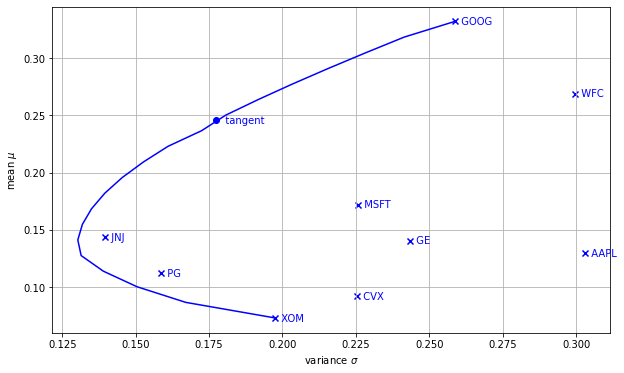

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.0,0.0,1.437751e-17,0.450921,5.156754e-17,0.528356,0.0,2.428645e-17,0.020723


In [12]:
## acá solamente llama todo lo que definimos arriba:

res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='blue')
display_frontier(res1, color='blue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), show()
display(pandas.DataFrame({'Weight': res1.W}, index=names).T)

## Proceso de estimación de Black-Litterman

In [13]:
# De los retornos y covarianzas muestrales calculamos el exceso de retorno en equilibrio para cada activo

## calcula media y varianza usando los pesos del portfolio basado en la capitalización de mercado
mean, var = port_mean_var(W, R, C)

## calcula lambda: el retorno del portfolio - la risk free dividido por la varianza del portfolio (no el desvío!)
lmb = (mean - rf) / var  # Calculate risk aversion

## calcula PI (los excesos de retornos de equilibrio):
## lambda por la matriz de covarianza por el vector de pesos:
Pi = dot(dot(lmb, C), W)  # Calculate equilibrium excess returns

##### Mean-variance Optimization (based on equilibrium returns)

,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.072993,0.039015,1.000000e+00,6.605827e-13,0.000000e+00,3.141376e-13,3.582690e-13,0.000000e+00,1.133815e-12,8.088530e-13,0.000000e+00
1,0.086623,0.027910,6.525565e-01,4.350102e-18,4.214942e-18,3.813821e-20,9.437481e-18,4.062084e-18,1.119462e-18,3.474435e-01,8.590960e-18
2,0.100252,0.022646,3.905911e-01,3.103467e-02,0.000000e+00,8.927201e-02,1.973198e-18,0.000000e+00,3.401048e-18,4.891022e-01,6.776493e-18
3,0.113882,0.019316,2.308184e-01,4.236269e-02,8.208681e-18,3.164561e-01,1.816711e-19,1.165723e-19,1.574483e-19,4.103628e-01,6.812667e-20
4,0.127512,0.017275,3.966216e-02,6.477689e-02,5.512069e-18,4.985239e-01,1.691047e-17,3.386599e-18,6.709428e-18,3.970371e-01,3.305920e-19
5,0.141142,0.016978,4.197770e-18,5.848363e-02,4.519457e-03,5.812659e-01,0.000000e+00,4.233498e-02,2.493693e-18,3.133961e-01,2.408449e-18
6,0.154772,0.017387,1.505035e-17,3.475837e-02,1.679275e-02,5.931526e-01,8.480291e-19,1.011843e-01,4.768213e-18,2.541120e-01,5.363508e-18
7,0.168401,0.018219,0.000000e+00,1.770310e-02,1.376996e-02,5.848931e-01,0.000000e+00,1.665644e-01,0.000000e+00,2.170695e-01,3.152640e-19
8,0.182031,0.019465,5.078829e-18,5.414829e-20,1.244427e-02,5.866871e-01,8.458733e-18,2.300904e-01,5.899066e-18,1.707783e-01,1.678096e-18
9,0.195661,0.021152,3.087275e-17,5.270226e-18,7.588878e-03,5.726063e-01,6.559430e-18,2.954613e-01,0.000000e+00,1.243436e-01,0.000000e+00


,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.094449,0.025152,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.307297e-15,7.450109e-16,0.000000e+00,1.000000e+00,8.565199e-15
1,0.100962,0.016955,0.000000e+00,4.707559e-02,5.233033e-18,6.207432e-01,0.000000e+00,1.053213e-20,0.000000e+00,3.321812e-01,3.539572e-18
2,0.107475,0.017038,2.343002e-18,6.832068e-02,6.285254e-02,5.477330e-01,8.693284e-18,2.011771e-02,1.121957e-18,3.009761e-01,1.024911e-17
3,0.113988,0.017640,9.895634e-19,1.003803e-01,8.555073e-02,4.902322e-01,0.000000e+00,5.916735e-02,1.612519e-19,2.646694e-01,0.000000e+00
4,0.120502,0.018727,5.056052e-02,1.141130e-01,9.690936e-02,4.271475e-01,8.937790e-03,7.497233e-02,0.000000e+00,2.273595e-01,0.000000e+00
5,0.127015,0.020136,9.596265e-02,1.242385e-01,1.050722e-01,3.620260e-01,3.346212e-02,8.220749e-02,1.172683e-03,1.958584e-01,1.043518e-18
6,0.133528,0.021847,1.101218e-01,1.328706e-01,1.106062e-01,3.009381e-01,5.352965e-02,9.162687e-02,2.598289e-02,1.700277e-01,4.296107e-03
7,0.140042,0.023824,1.231884e-01,1.397345e-01,1.108260e-01,2.488761e-01,6.945930e-02,9.589034e-02,4.862191e-02,1.437511e-01,1.965231e-02
8,0.146555,0.026086,1.037329e-01,1.473963e-01,1.141123e-01,1.599534e-01,7.743931e-02,1.079425e-01,8.077240e-02,1.633450e-01,4.530596e-02
9,0.153068,0.028537,1.097748e-01,1.518757e-01,1.123424e-01,1.269897e-01,9.027001e-02,1.138525e-01,9.615999e-02,1.268773e-01,7.185751e-02


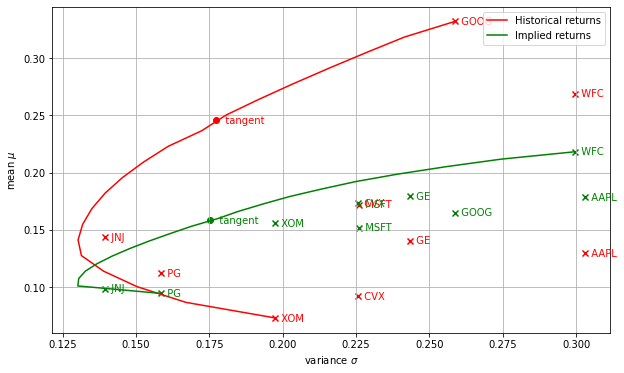

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


In [14]:
## hace la optimización de portfolio pero en vez de usar los retornos originales
## usa los excesos de retornos de equilibrio (Pi) + la risk free (para tener el retorno de equilibrio). 
## Usa la matriz de varianzas y covarianzas que ya tenía:
res2 = optimize_frontier(Pi+rf, C, rf)

## llama las funciones que ya definimos para plotear todo:
display_assets(names, R, C, color='red')

## en rojo plotea la frontera eficiente con retornos históricos
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')

## en verde plotea la frontera eficiente con los retornos de equilibrio
display_frontier(res2, label='Implied returns', color='green')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pandas.DataFrame({'Weight': res2.W}, index=names).T)

##### Expresamos las views (Q) y la matriz que conecta con los activos a dichas views (P)

In [15]:
## ahora va a crear las views y la matriz para linkear

def create_views_and_link_matrix(names, views):
    ## toma como input una lista de nombres y una lista de views
    
    ## toma el largo de ambas listas
    r, c = len(views), len(names)
    
    ## se ve que las views tienen un formato definido
    ## abajo define un ejemplo.
    ## en la posición 3 está el exceso de retorno de un activo
    ## con respecto a otro
    ## por eso lo extrae:
    Q = [views[i][3] for i in range(r)]  # view matrix
    
    ## define una matriz de 0 con r filas y c columnas
    P = zeros([r, c])
    ## define un diccionario vacío
    nameToIndex = dict()
    
    ## enumerate te permite iterar sobre la lista "names"
    ## pero también te devuelve la posición. Por ejemplo:
    ## en la primera vuelta "i" va a valer 0 
    ## y "n" vale el primer nombre. En la segunda vuelta
    ## "i" vale 1 y "n" el segundo nombre de la lista names, y así
    for i, n in enumerate(names):
        ## guarda en el diccionario, para la key n (el nombre)
        ## el numero de orden en la lista names
        nameToIndex[n] = i
        
    ## ahora itera sobre las views
    for i, v in enumerate(views):
        ## guarda en name1 el nombre del primer activo de la view (posición 0)
        ## y en name2 el nombre del segundo activo de la view (posición 2)
        ## en la posición 1 hay un mayor o menor. 
        ## por ejemplo, si la view es MSFT > GE 0.02 es que espera un 2%
        ## más de retorno de parte de msft que de GE
        name1, name2 = views[i][0], views[i][2]
        
        ## guarda en P (la matriz de 0 que definimos arriba)
        ## para la fila i, y la columna correspondiente al ticker en nombre1 
        ## (la posición la guardamos arriba en el diccionario)
        ## 1 en caso del mayor y -1 en caso del menor.
        
        ## para el ejemplo de msft > ge 0.02 lo que hace es guardar
        ## en la fila 0, para la columna 2 (el ticker de la posición 2 de names
        ## es msft) un 1
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
        
    ## devuelve Q (matriz de views) y P (matriz de links)
    return array(Q), P

views = [('MSFT', '>', 'GE', 0.02),
         ('AAPL', '<', 'JNJ', 0.02)]

Q, P = create_views_and_link_matrix(names, views)
print('Views Matrix')
display(DataFrame({'Views':Q}))
print('Link Matrix')
display(DataFrame(P))

Views Matrix


,Views
0,0.02
1,0.02


Link Matrix


,0,1,2,3,4,5,6,7,8
0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


##### Optimización de BL

,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.094449,0.025152,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.307297e-15,7.450109e-16,0.000000e+00,1.000000e+00,8.565199e-15
1,0.100962,0.016955,0.000000e+00,4.707559e-02,5.233033e-18,6.207432e-01,0.000000e+00,1.053213e-20,0.000000e+00,3.321812e-01,3.539572e-18
2,0.107475,0.017038,2.343002e-18,6.832068e-02,6.285254e-02,5.477330e-01,8.693284e-18,2.011771e-02,1.121957e-18,3.009761e-01,1.024911e-17
3,0.113988,0.017640,9.895634e-19,1.003803e-01,8.555073e-02,4.902322e-01,0.000000e+00,5.916735e-02,1.612519e-19,2.646694e-01,0.000000e+00
4,0.120502,0.018727,5.056052e-02,1.141130e-01,9.690936e-02,4.271475e-01,8.937790e-03,7.497233e-02,0.000000e+00,2.273595e-01,0.000000e+00
5,0.127015,0.020136,9.596265e-02,1.242385e-01,1.050722e-01,3.620260e-01,3.346212e-02,8.220749e-02,1.172683e-03,1.958584e-01,1.043518e-18
6,0.133528,0.021847,1.101218e-01,1.328706e-01,1.106062e-01,3.009381e-01,5.352965e-02,9.162687e-02,2.598289e-02,1.700277e-01,4.296107e-03
7,0.140042,0.023824,1.231884e-01,1.397345e-01,1.108260e-01,2.488761e-01,6.945930e-02,9.589034e-02,4.862191e-02,1.437511e-01,1.965231e-02
8,0.146555,0.026086,1.037329e-01,1.473963e-01,1.141123e-01,1.599534e-01,7.743931e-02,1.079425e-01,8.077240e-02,1.633450e-01,4.530596e-02
9,0.153068,0.028537,1.097748e-01,1.518757e-01,1.123424e-01,1.269897e-01,9.027001e-02,1.138525e-01,9.615999e-02,1.268773e-01,7.185751e-02


,Mean,Variance,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
0,0.092353,0.025152,0.000000e+00,0.000000e+00,0.000000e+00,1.804112e-15,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,0.000000e+00
1,0.098291,0.017119,4.219328e-18,2.515277e-02,6.082865e-18,5.878508e-01,8.384910e-19,0.000000,1.166459e-18,3.869964e-01,0.000000e+00
2,0.104230,0.017008,6.436660e-19,7.391060e-02,5.545525e-02,5.730364e-01,8.430536e-19,0.009776,2.848902e-18,2.878216e-01,0.000000e+00
3,0.110168,0.017632,2.684228e-21,6.867053e-02,1.390220e-01,4.946734e-01,1.278639e-19,0.032769,5.925411e-19,2.648652e-01,8.163863e-19
4,0.116107,0.018710,4.713852e-02,5.908301e-02,1.595332e-01,4.516192e-01,0.000000e+00,0.077144,2.439455e-19,2.054819e-01,4.982726e-19
5,0.122045,0.020204,1.065968e-01,5.544063e-02,1.833819e-01,3.869452e-01,0.000000e+00,0.090611,1.228458e-02,1.647394e-01,1.626303e-19
6,0.127984,0.022027,1.200211e-01,4.366116e-02,2.069981e-01,3.273472e-01,2.530078e-20,0.093748,4.038519e-02,1.465857e-01,2.125360e-02
7,0.133922,0.024120,1.303412e-01,4.482988e-02,2.126512e-01,2.582771e-01,0.000000e+00,0.101461,7.269578e-02,1.341167e-01,4.562733e-02
8,0.139860,0.026494,1.355208e-01,3.906677e-02,2.356049e-01,2.037183e-01,7.235376e-03,0.123212,9.682307e-02,1.015462e-01,5.727241e-02
9,0.145799,0.029088,1.461930e-01,2.577537e-02,2.518413e-01,1.724859e-01,9.181420e-04,0.129722,1.152161e-01,6.707612e-02,9.077195e-02


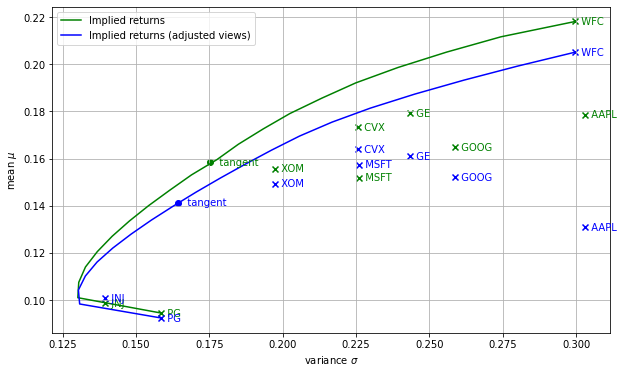

,XOM,AAPL,MSFT,JNJ,GE,GOOG,CVX,PG,WFC
Weight,0.160429,0.15617,0.112453,0.097424,0.093807,0.116209,0.091813,0.084692,0.087002


In [16]:
## ya casi estamos! jaja
## hace la optimización de black literman:

## lo que va a hacer es tomar las views y la matriz de link
## y lo va a combinar con la matriz de covarianzas que teníamos 
## para calcular los retornos según esta técnica para meter en el optimizador

## define tau
tau = .025  # scaling factor

## acá arrancan las cuentas, por ahí es más fácil seguirlo mirando el apunte
## con las cuentas
## nota : ** significa elevar. Por ejemplo 2**4 es elevar 2 a la 4. 
## y 2**-1 significa elevar 2 a la -1. O sea, C**-1 es "invertí C"

## calcula omega: ((tau * P) * C) * P_traspuesta

# Calculate omega - uncertainty matrix about views
omega = dot(dot(dot(tau, P), C), transpose(P))  # 0.025 * P * C * transpose(P)


# Calculate equilibrium excess returns with views incorporated
## invierte tau*C
sub_a = inv(dot(tau, C))

## hace (P_traspuesta * (Omega **-1)) ** P
sub_b = dot(dot(transpose(P), inv(omega)), P)

## hace ((tau * C)**-1 ) * Pi
sub_c = dot(inv(dot(tau, C)), Pi)

## (P_traspuesta * (Omega**-1))*Q
sub_d = dot(dot(transpose(P), inv(omega)), Q)

## suma sub_a y sub_b. Invierte eso
## y lo multiplica por la suma de sub_c y sub_d 
## esto estaría en la página 10 de las diapos
Pi_adj = dot(inv(sub_a + sub_b), (sub_c + sub_d))

## usa esta cuenta nos da los excesos de retorno
## por loque le sumamos la risk free para tener retornos
## y hacemos la optimización con eso.
## usamos la matriz de varianzas y covarianzas que ya teníamos.
res3 = optimize_frontier(Pi_adj + rf, C, rf)

## ploteamos todo
display_assets(names, Pi+rf, C, color='green')

## en azul vamos a plotear esta frontera eficiente
## y en verde ploteamos la anterior que calculamos más arriba
display_frontier(res2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='Implied returns (adjusted views)', color='blue')
xlabel('variance $\sigma$'), ylabel('mean $\mu$'), legend(), show()
display(pandas.DataFrame({'Weight': res2.W}, index=names).T)